# Génération du Labyrinthe

> L'objectif de ce notebook est d'entrainer un modèle à générer des labyrinthes complexes et infinis en utilisant les cartes d'exemple disponibles dans ce même répertoire.

## Génération du dataset

Dans un premier temps, nous cherchons à obtenir un dataset de la forme suivante :
$$
\text{Voisinage} \rightarrow \text{Case}
$$
Pour ce faire, nous allons reprendre l'idée des filtres de convolution et balayer le labyrinthe avec un filtre de taille $n\times n$.

In [14]:
# -------------------------- CHARGEMENT DES DONNEES -------------------------- #
import pandas as pd
import os
from IPython.display import display, Markdown

data = {}
for root, dirs, files in os.walk("."):
    for filename in sorted(files):
        if filename.endswith(".csv"):
            last_character = filename[-5]
            simple_filename = filename.split(".")[0]
            if simple_filename not in data:
                data[simple_filename] = {}
            if last_character not in data[simple_filename]:
                try:
                    csv = pd.read_csv(filename).to_numpy()
                except:
                    continue
                if csv.shape[0] * csv.shape[1] != 0:
                    data[simple_filename][last_character] = csv

for data_name in data:
    display(Markdown(f"-> **{data_name}** : *{len(data[data_name])} layers*"))

-> **training_map** : *2 layers*

In [35]:
# --------------------------- CREATON DES DATASETS --------------------------- #
import numpy as np


def create_datasets(data_list: list, neighbourhood: int = 1, training : bool = True):
    window_size = neighbourhood * 2 + 1

    datasets = {}
    for key, data in data_list.items():
        # Add padding of size window_size // 2 with -1
        data = data.astype(str)
        data = np.pad(data, window_size, constant_values="border")
        dataset = pd.DataFrame(
            [
                data[i : i + window_size, j : j + window_size].flatten()
                for i in range(0, data.shape[0] - window_size + 1)
                for j in range(0, data.shape[1] - window_size + 1)
            ]
        )
        dataset["label"] = dataset[dataset.columns[(window_size**2 - 1) // 2]]
        dataset.drop(dataset.columns[(window_size**2 - 1) // 2], axis=1, inplace=True)
        dataset = dataset[dataset["label"] != "border"]
        dataset = dataset.replace("border", -1)
        dataset = dataset.astype(int)
        
        # Sample the dataset
        if training:
            dataset = dataset.sample(frac=1).reset_index(drop=True)

        datasets[key] = dataset

    result_datasets = {}
    for key in datasets:
        result_datasets[key] = (
            pd.concat(
                [dataset.drop(columns=["label"]) for dataset in datasets.values()]
                + [datasets[key]["label"]],
                axis=1,
            )
            .fillna(-1)
            .astype(int)
        )

    return result_datasets


datasets = {data_name: create_datasets(data[data_name]) for data_name in data}
for dataset in datasets:
    for layer in datasets[dataset]:
        display(
            Markdown(
                f"-> **{dataset}** : *{layer} : {len(datasets[dataset][layer])} samples*"
            )
        )

-> **training_map** : *1 : 528 samples*

-> **training_map** : *2 : 528 samples*

In [41]:
# --------------------------------- PLOT MAP --------------------------------- #
import os
import pygame
import itertools
from IPython.display import Image


def plot_map(mazes: dict):
    width, height = mazes[list(mazes.keys())[0]].shape

    assets = {}
    for root, dirs, files in os.walk(os.path.join("..", "frames")):
        # Remove files starting with a capital letter
        files = [f for f in files if not f[0].isupper()]
        for i, filename in enumerate(sorted(files)):
            if i in list(
                itertools.chain.from_iterable(
                    [maze.flatten().tolist() for maze in mazes.values()]
                )
            ):
                assets[i] = pygame.image.load(os.path.join(root, filename))
    # Create a black image for -1 (16x16) with alpha channel
    assets[-1] = pygame.Surface((16, 16), pygame.SRCALPHA)

    # Create window
    pygame.init()
    screen = pygame.display.set_mode((width * 16, height * 16))
    pygame.display.set_caption("Maze")
    screen.fill((0, 0, 0))

    # Draw the mazes
    for maze in mazes.values():
        for i in range(width):
            for j in range(height):
                screen.blit(assets[maze[i, j]], (j * 16, i * 16), special_flags=0)

    pygame.display.flip()
    pygame.image.save(screen, "maze.png")
    pygame.quit()

    # Display the maze
    display(Image(filename="maze.png"))

[[115 115 115]
 [115 115 115]
 [115 115 115]]
[[ -1 265  -1]
 [ -1 115  -1]
 [ -1 265  -1]]


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


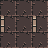

In [37]:
cell = datasets["training_map"]["1"].sample(1)
label = cell["label"]
first_layer = pd.concat([cell.iloc[0, 0:4], label, cell.iloc[0, 4:8]], axis=0).to_numpy().reshape(3, 3)
second_layer = pd.concat([cell.iloc[0, 8:12], label, cell.iloc[0, 12:16]], axis=0).to_numpy().reshape(3, 3)
to_display = {1: first_layer, 2: second_layer}
print(first_layer)
print(second_layer)
plot_map(to_display)

In [16]:
# ------------------------------ TRAINING MODELS ----------------------------- #
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    dataset: {
        layer: {
            "model": RandomForestClassifier(verbose=True, n_jobs=-1, n_estimators=10).fit(
                datasets[dataset][layer].drop("label", axis=1),
                datasets[dataset][layer]["label"],
            ),
            "window_size": int(
                (np.sqrt(datasets[dataset][layer].shape[1] - 1) // 2 + 1)
            ),
            # List of unique value in the dataframe
            "assets": dict(
                zip(
                    *np.unique(
                        datasets[dataset][layer].to_numpy().flatten(),
                        return_counts=True,
                    )
                )
            ),
        }
        for layer in datasets[dataset]
    }
    for dataset in datasets
}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [18]:
# ------------------------------ GENERATING MAZE ----------------------------- #
import numpy as np


def generate_maze(classifiers: dict, size: tuple, nbr_iter=50, temperature=0.1, sample_percent=0.1):
    mazes = {}

    # Unpack Arguments
    size_x, size_y = size
    window_size = classifiers[list(classifiers.keys())[0]]["window_size"]
    assets_list = {key: classifier["assets"] for key, classifier in classifiers.items()}
    models = {key: classifier["model"] for key, classifier in classifiers.items()}

    # Generate Maze
    ## Generate a matrix full of random values from the assets
    mazes = {
        key: np.random.choice(
            list(assets.keys()),
            (size_x, size_y),
            p=list(assets.values()) / np.sum(list(assets.values())),
        )
        for key, assets in assets_list.items()
    }

    # Apply the classifier on the maze
    for _ in range(nbr_iter):
        # Generate dataset from the maze
        datasets = create_datasets(mazes, window_size // 2, training=False)

        for key, model in models.items():
            # Sample the dataset
            inputs = datasets[key].drop("label", axis=1).sample(frac=sample_percent)
            
            # Apply the classifier on the dataset
            logits = model.predict_proba(inputs)
            logits = logits ** (1 / temperature)
            predictions = np.array(
                [
                    np.random.choice(model.classes_, p=logit / logit.sum())
                    for logit in logits
                ]
            )
            datasets[key]["label"].loc[inputs.index] = predictions

            # Recreate the maze from the predictions
            mazes[key] = datasets[key]["label"].to_numpy().reshape(size_x, size_y)

    return mazes


mazes = generate_maze(classifiers["training_map"], (25, 25))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 co

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


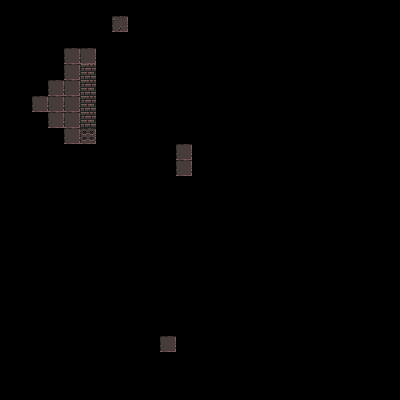

In [19]:
plot_map(mazes)